<div class="markdown-google-sans">
  <h1>Решение задачи детекции людей на снимках с квадракоптера</h1>
</div>

Подключим все необходимые файлы github 

In [1]:
!git clone https://github.com/BerezinDaniil/RCNN.git

fatal: destination path 'RCNN' already exists and is not an empty directory.


Подключим гугл-диск с данными train и test

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Подключение необходимых библиотек

In [3]:
import os
import pandas as pd
import pycocotools
import numpy as np
import torch
import torch.utils.data
import pandas as pd
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from RCNN.engine import train_one_epoch, evaluate
import RCNN.utils
import RCNN.transforms as T
from PIL import ImageDraw
import csv
import random
import cv2
import matplotlib.pyplot as plt
import json

<div class="markdown-google-sans">
  <h1>Подготовка данных</h1>
</div>

Посмотрим на данные

In [4]:
train_data = pd.read_csv("/content/drive/MyDrive/train_dataset_train (2)/train.csv")

In [5]:
train_data.head()

,ID_img,count_region,region_shape
0,3376.JPG,0.0,0.0
1,3377.JPG,0.0,0.0
2,3378.JPG,0.0,0.0
3,3379.JPG,0.0,0.0
4,3380.JPG,0.0,0.0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5064 entries, 0 to 5063
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID_img        5064 non-null   object 
 1   count_region  5064 non-null   float64
 2   region_shape  5064 non-null   object 
dtypes: float64(1), object(2)
memory usage: 118.8+ KB


In [7]:
train_data[train_data["count_region"] > 0].count()

ID_img          58
count_region    58
region_shape    58
dtype: int64

Видим, что из 5064 изображений люди присутствуют только на 58

In [8]:
real_data = train_data[train_data["count_region"] > 0]

In [9]:
real_data.head()

,ID_img,count_region,region_shape
395,3771.JPG,1.0,"['{""cx"":2715,""cy"":419,""r"":133}']"
409,3785.JPG,1.0,"['{""cx"":2719,""cy"":2097,""r"":75}']"
429,3805.JPG,1.0,"['{""cx"":3220,""cy"":1280,""r"":185}']"
523,3899.jpg,1.0,"['{""cx"":4125,""cy"":2129,""r"":80}']"
675,4051.JPG,5.0,"['{""cx"":2396,""cy"":1187,""r"":111}', '{""cx"":2765,..."


Попробуем увеличить обучающую выборку

Добавим фотографии с людьми в отдельную папку

In [ ]:
os.mkdir("/content/drive/MyDrive/train_dataset_train (2)/train_1/")
for name in np.array(real_data["ID_img"]):
  image = Image.open(f'/content/drive/MyDrive/train_dataset_train (2)/train/{name}')
  image.save(f'/content/drive/MyDrive/train_dataset_train (2)/train_1/{name.split(".")[0]}.jpg')

Поворот изображений вправо

In [ ]:
for name in np.array(real_data["ID_img"]):
  image = Image.open(f'/content/drive/MyDrive/train_dataset_train (2)/train/{name}').rotate(90, expand=True)
  image.save(f'/content/drive/MyDrive/train_dataset_train (2)/train_1/{name.split(".")[0]}_right.jpg')

Поворот изображений влево

In [ ]:
for name in np.array(real_data["ID_img"]):
  image = Image.open(f'/content/drive/MyDrive/train_dataset_train (2)/train/{name}').rotate(-90, expand=True)
  image.save(f'/content/drive/MyDrive/train_dataset_train (2)/train_1/{name.split(".")[0]}_left.jpg')

Переворот всех изображений

In [ ]:
directory = '/content/drive/MyDrive/train_dataset_train (2)/train_1/'
files = os.listdir(directory)
files = [f for f in files if f.split(".")[0].split("_")[-1] != "inverted"]


In [ ]:
for name in files:
  image = Image.open(directory+name).transpose(Image.FLIP_TOP_BOTTOM)
  image.save(directory+name.split(".")[0]+"_"+"inverted"+".jpg")

Преобразуем датафрейм к нужному нам виду

In [10]:
d_real_data = {}
for i in range(len(np.array(real_data["region_shape"]))):
  if np.array(real_data["ID_img"])[i] not in d_real_data.keys():
    d_real_data[np.array(real_data["ID_img"])[i].lower()] = []
  if np.array(real_data["region_shape"])[i][1:-1].count(",") == 2:
    d_real_data[np.array(real_data["ID_img"])[i].lower()].append(json.loads(np.array(real_data["region_shape"])[i][2:-2]))
  else:
    for j in np.array(real_data["region_shape"])[i][1:-1].split(", "):
      d_real_data[np.array(real_data["ID_img"])[i].lower()].append(json.loads(j[1:-1]))

Добавим туда повернутые на 90 и 270 градусов изображения

In [11]:
directory = '/content/drive/MyDrive/train_dataset_train (2)/train_1/'
files = os.listdir(directory)
for n in files:
  if n.count("_") != 0 and n.split(".")[0].split("_")[1] == 'right':
    d_real_data[n] = []
    im = Image.open(directory+n.split(".")[0].split("_")[0]+".jpg")
    X,Y = im.size
    for i in range(len(d_real_data[n.split(".")[0].split("_")[0]+".jpg"])):
      d = {'cx': d_real_data[n.split(".")[0].split("_")[0]+".jpg"][i]["cy"],
           'cy': X - d_real_data[n.split(".")[0].split("_")[0]+".jpg"][i]["cx"],
           'r': d_real_data[n.split(".")[0].split("_")[0]+".jpg"][i]["r"]}
      d_real_data[n].append(d)
  if n.count("_") != 0 and n.split(".")[0].split("_")[1] == 'left':
    d_real_data[n] = []
    im = Image.open(directory+n.split(".")[0].split("_")[0]+".jpg")
    X,Y = im.size
    for i in range(len(d_real_data[n.split(".")[0].split("_")[0]+".jpg"])):
      d = {'cx': Y - d_real_data[n.split(".")[0].split("_")[0]+".jpg"][i]["cy"],
           'cy': d_real_data[n.split(".")[0].split("_")[0]+".jpg"][i]["cx"],
           'r': d_real_data[n.split(".")[0].split("_")[0]+".jpg"][i]["r"]}
      d_real_data[n].append(d)

Добавим перевернутые изображения

In [12]:
directory = '/content/drive/MyDrive/train_dataset_train (2)/train_1/'
files = os.listdir(directory)
for n in files:
    if n.count("_") != 0 and n.split(".")[0].split("_")[-1] == 'inverted':
      d_real_data[n] = []
      im = Image.open(directory+"_".join(n.split(".")[0].split("_")[:-1])+".jpg")
      X,Y = im.size
      for i in range(len(d_real_data["_".join(n.split(".")[0].split("_")[:-1])+".jpg"])):
        d = {'cx': d_real_data["_".join(n.split(".")[0].split("_")[:-1])+".jpg"][i]["cx"],
            'cy': Y-d_real_data["_".join(n.split(".")[0].split("_")[:-1])+".jpg"][i]["cy"],
            'r': d_real_data["_".join(n.split(".")[0].split("_")[:-1])+".jpg"][i]["r"]}
        d_real_data[n].append(d)

Таким образом мы увеличели выборку с людьми в 6 раз, с 58 фотографий до 348

Сохраним данные в .csv файл, и сразу перевейдем от окружностей к прямоугольникам, с которыми работает fasterRCNN

In [13]:
with open("box_train.csv", mode="w", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=",", lineterminator="\r")
    file_writer.writerow(["filename","class", 'xmin', "ymin", 'xmax', 'ymax'])
    for i in d_real_data.keys():
      for j in d_real_data[i]:
        file_writer.writerow(
            [i,1, int(j['cx'])-int(j['r']) if int(j['cx'])-int(j['r'])>0 else 0,int(j['cy'])-int(j['r']),int(j['cx'])+int(j['r']),int(j['cy'])+int(j['r'])])

Функция для отрисовывание боксов 

In [14]:
full_labels = pd.read_csv('box_train.csv')

def draw_boxes(image_name):
  selected_value = full_labels[full_labels.filename == image_name]
  img = cv2.imread('/content/drive/MyDrive/train_dataset_train (2)/train_1/{}'.format(image_name))
  for index, row in selected_value.iterrows():
      img = cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 255, 0), 5)
  return img

Проверим, не ошиблись ли мы с преобразованиями координат

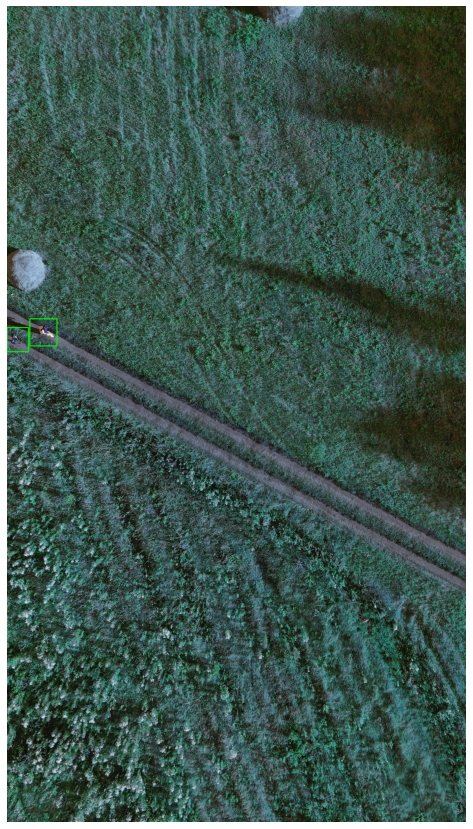

In [16]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(Image.fromarray(draw_boxes('5149_right_inverted.jpg')))

plt.show()

<div class="markdown-google-sans">
  <h1>Обучение</h1>
</div>

In [17]:
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data['filename'] == filename][['xmin', "ymin", 'xmax', 'ymax']].values
    return boxes_array


In [18]:
class PeopleDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        #Перемешаем массив с изображениями, что бы более честно разделить на test и train
        random.seed(42)
        self.imgs = sorted(os.listdir(os.path.join(root, "train_1")))
        random.shuffle(self.imgs)
        self.path_to_data_file = data_file

    def __getitem__(self, idx):
        # Загрузка боксов и картинок
        img_path = os.path.join(self.root, "train_1", self.imgs[idx])
        img = Image.open(img_path) 
        box_list = parse_one_annot(self.path_to_data_file,
                                   self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)


In [19]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [20]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [21]:
# use our dataset and defined transformations
dataset = PeopleDataset(root="/content/drive/MyDrive/train_dataset_train (2)/",
                         data_file="box_train.csv",
                         transforms=get_transform(train=True))
dataset_test = PeopleDataset(root="/content/drive/MyDrive/train_dataset_train (2)/",
                              data_file="box_train.csv",
                              transforms=get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=RCNN.utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=RCNN.utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 348 examples, 298 are training and 50 testing


In [ ]:
#os.mkdir("/content/drive/MyDrive/pytorch object detection/")

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2 #!
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
# let's train it for 30 epochs
num_epochs = 30
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch,
                    print_freq=5)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

#os.mkdir("/content/drive/MyDrive/pytorch object detection/")
torch.save(model.state_dict(), "/content/drive/MyDrive/pytorch object detection/model_30_full_train")

Оценним качество модели на примерах 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loaded_model = get_model(num_classes=2)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/pytorch object detection/model_30_full_train', map_location=torch.device(device)))

for idx in range(len(dataset_test)):
    img, _ = dataset_test[idx]
    label_boxes = np.array(dataset_test[idx][1]["boxes"])
    # put the model in evaluation mode
    loaded_model.eval()
    with torch.no_grad():
        prediction = loaded_model([img])
        # print(prediction)
    image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    draw = ImageDraw.Draw(image)
    # draw groundtruth
    for elem in range(len(label_boxes)):
        draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
                        (label_boxes[elem][2], label_boxes[elem][3])],
                       outline="green", width=10)
    # print(len(prediction[0]["boxes"]))
    for element in range(len(prediction[0]["boxes"])):
        boxes = prediction[0]["boxes"][element].cpu().numpy()
        score = prediction[0]["scores"][element].cpu().numpy()
        if score > 0.90:
          print(score)
          draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])],
                       outline="red", width=5)
          draw.text((boxes[0], boxes[1]), text=str(score))

    plt.figure(figsize=(60,60))
    plt.axis("off")
    plt.imshow(image)

    plt.show()

<div class="markdown-google-sans">
  <h1>Предсказание</h1>
</div>

Сначала отберем фото, на которых предположительно есть люди

In [ ]:
from sklearn.linear_model import LinearRegression
directory = '/content/drive/MyDrive/train_dataset_train (2)/train/'
files = os.listdir(directory)
Y = np.array([1 if f in np.array(real_data["ID_img"]) else 0 for f in files])
X = []
for f in files:
  im = Image.open(directory+f)
  x,y = im.size
  X.append([x,y])
X = np.array(X)

In [ ]:
X_1 = []
y_1 = []
X_0 = []
y_0 =[]
for i in range(len(X)):
  if Y[i] == 1:
    X_1.append(X[i][0])
    y_1.append(X[i][1])
  else:
    X_0.append(X[i][0])
    y_0.append(X[i][1])

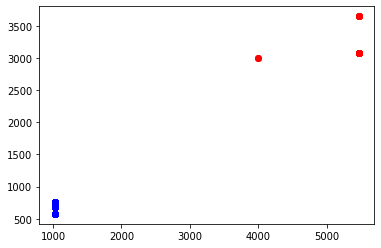

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X_1,y_1, c = 'red')
plt.scatter(X_0,y_0, c = 'blue')
plt.show()

Видим, что фото с людьми и без линейно разделимы просто по размеру фотографий

Обучим линейный классификатор

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42,stratify=Y)

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
reg.score(X_test, y_test)

0.9982405099998374

In [ ]:
directory = '/content/drive/MyDrive/test_dataset_test (2)/test/'
files = os.listdir(directory)
tr_f = []
for f in files:
  X = []
  im = Image.open(directory+f)
  x,y = im.size
  X.append([x,y])
  if reg.predict(X) > 0.5:
    tr_f.append(f)

In [ ]:
tr_f

Данный пункт выглядит очень привлекательно, если использовать только фото в хорошем разрешении то можно получить скор около 0.48
Однако после анализа всех фотографий видим, что в test-е не все так радужно, как в train-e

<div class="markdown-google-sans">
  <h1>Детекция людей на фото</h1>
</div>

Скачиваем обученную нами модель

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loaded_model = get_model(num_classes=2)
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/pytorch object detection/model_30_full_train', map_location=torch.device(device)))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
directory = '/content/drive/MyDrive/test_dataset_test (2)/test/'
files = os.listdir(directory)
with open("box_test.csv", mode="w", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=",", lineterminator="\r")
    file_writer.writerow(["filename","class", 'xmin', "ymin", 'xmax', 'ymax'])
    for f in files: #tr_f
      file_writer.writerow(
            [f,1,0,0,0,0])

Класс датасета для предсказаний

In [ ]:
class Dataset_test(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "test")))
        self.path_to_data_file = data_file

    def __getitem__(self, idx):
        # Загрузка боксов и картинок
        img_path = os.path.join(self.root, "test", self.imgs[idx])
        img = Image.open(img_path)
        box_list = parse_one_annot(self.path_to_data_file,
                                   self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        #print(num_objs)
        # У нас пока один класс
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset_test = Dataset_test(root="/content/drive/MyDrive/test_dataset_test (2)/",
                              data_file="box_test.csv",
                              transforms=get_transform(train=False))

In [ ]:
IDX = [56,62,128,164,188,246,259,264,311,403,414,466,493,503,535,536,554,566,570,575,573,580,606,
       686,720,803,920,928,945,946,984,1006,1064,1073,1140,1156,1163,1166,1191,1207,1220,1241,1252,
       1273,1276,1284,1300,1351,1391,1397,1449,1461,1524,1554,1600,1615,1622,1631,1632,1635,1686,
       1697,1742,1760,1842,1919,1966,1982,1983,1992,2026,2038,2057,2070,2082,2147,2191,2193,2256,
       2262,2331,2380,2389,2394,2404,2411,2432,2433,2513,2582,2602,2634,2634,2650,2656,2701,2736,
       2745,2789,2840,2854,2858,2878,2886,2904,2913,2934,2944,3000,3008,3012,3036,3063,3101,3109,
       3137,3142,3161,3202,3203,3204,3260,3314,3382]

Нахождение боксов с людьми на изображениях, в данном цикле мы пробегаемся по всем фото из test, в массиве IDX находятся порядковые номера(из sorted(os.listdir(os.path.join("/content/drive/MyDrive/test_dataset_test (2)/", "test")))) тех фото, на которых вероятность найти человека больше 90%(Бегать по всем долго, около 6ти часов, так что после первого раза все номера были записаны в этот массив)

In [ ]:
ANS_pred = {}
test = sorted(os.listdir(os.path.join("/content/drive/MyDrive/test_dataset_test (2)/", "test")))
print(len(test))
for idx in range(len(dataset_test)): # IDX
    print(idx, "/", len(dataset_test))
    img, _ = dataset_test[idx]
    loaded_model.eval()
    with torch.no_grad():
        prediction = loaded_model([img])
    score = np.round(prediction[0]["scores"].cpu().numpy(),
                         decimals=4)
    if len(score)>0:
      if max(score)>0.90:
        print(max(score))
        ANS_pred[test[idx]] = []
        for i in range(len(prediction[0]["scores"].cpu().numpy())):
          if prediction[0]["scores"].cpu().numpy()[i]>0.90:
            label_boxes = prediction[0]["boxes"][i].cpu().numpy()
            cx = min(label_boxes[0],label_boxes[2])+((max(label_boxes[0],label_boxes[2])-min(label_boxes[0],label_boxes[2]))//2)
            cy = min(label_boxes[1],label_boxes[3])+((max(label_boxes[1],label_boxes[3])-min(label_boxes[1],label_boxes[3]))//2)
            r = (((max(label_boxes[0],label_boxes[2])-min(label_boxes[0],label_boxes[2]))//2)**2 + (((max(label_boxes[1],label_boxes[3])-min(label_boxes[1],label_boxes[3]))//2))**2)**0.5
            ans = {"cx": cx,
                   "cy": cy,
                   "r": r}
            ANS_pred[test[idx]].append(ans)
print(ANS_pred)

Сортируем по cx и cy

In [ ]:
ANS_n = {}
for g in ANS_pred.keys():
  ANS_n[g] = []
  ANS_n[g] = sorted(ANS_pred[g], key=lambda d: (d['cx'], d['cy']))
ANS_n

Кастуем к строкам

In [ ]:
ANSS = {}
for i in ANS_n.keys():
  if len(ANS_n[i])>0:
    ANSS[i] = []
    for j in ANS_n[i]:
      ANSS[i].append(str(j))
  else:
    ANSS[i] = 0
ANSS


Объединяем с фото, на которых нет людей

In [ ]:
directory = '/content/drive/MyDrive/test_dataset_test (2)/test/'
files = os.listdir(directory)
ANS_1 = {}
for i in files:
  if i in ANSS.keys():
    ANS_1[i] = ANSS[i]
  else:
    ANS_1[i] = 0
ANS_1

Сохраняем предсказание в файл

In [ ]:
with open("answer.csv", mode="w", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=",", lineterminator="\r")
    file_writer.writerow(["ID_img","region_shape"])
    for i in ANS_1:
        file_writer.writerow([i,ANS_1[i]])